# Logistic Regression

Time for some learning.  This file contains my implementations of several methods used in creating and testing a binary logistic regression function.  
* A method for loading data into the design matrix.
* ... computing the sigmoid function,
* ... computing the gradient of the sigmoid function,
* ... computing the Hessian of the sigmoid function,
* ... computing the diagonal expected value matrix used in the Hessian computation,
* a steepest descent with and without a momentum term to update weights, and
* an iteratively reweighted least squares update method (bug: has problems with singular matrices).

The file also contains the following synthetic test material:
* A synthetic data constructor for normally distributed random vectors,
* labels generated for the synthetic data, and
* plots of 1-D regressor weights from the fitting process on the synthetic data.

The file also contains the following real-data tests:
* Data from the Donner Party taken from *Introduction to Regression Modeling by Abraham and Ledolter (2006), pg 368*
* A fitting of regressors on said data, and
* classifiers from SK-Learn for comparison and validation of the methods herein.

Lastly, the file contains my application of the logistic regression classifiers to the SE Data for Albany from a previous project.


#### Loading the necessary libraries:

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from sklearn.preprocessing import MaxAbsScaler
import random

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

#### Implementations of the aforementioned methods:

In [2]:
def loadData(listX):
    '''Expects listX to be a list, array, or tuple of N vectors D x 1.
    
    Loads them into the design matrix [1 x0 x2 x3 ... xD-1]
    with dimensions N x D.'''
    
    X = np.ones([len(listX),listX[0].shape[0]+1])
    for row in range(X.shape[0]):
        for col in range(X.shape[1]):
            if col != 0:
                X[row,col] = listX[row][col-1]
    return X

def sigm(x,w):
    '''Assumes:
    x is a (N+1) x 1 vector random variable w/ x0 = 1: (1 x1 x2 ... xN).
    w is a (N+1) x 1 vector of weights (w0 w1 w2 ... wN).
    
    Returns the sigmoid function 1/(1+e^(-w^T*x)).'''
    sum = 0
    for i in range(len(x)):
        sum = sum + x[i]*w[i]
    return 1/(1+np.exp(-sum))

def gSigm(X,w,y):
    '''Assumes X is a matrix of the data padded with 1s, i.e.
    for data set {x_1,...,x_n} of vectors, X = (1 x1 \\ 1 x2 \\ ... \\ 1 xn)
    where each vector forms most of a row of X.
    and
    y is a vector of the binary class labels.
    
    Returns the gradient vector of the sigmoid funciton.'''

    mu = np.array([sigm(X[i],w) for i in range(X.shape[0])])
    
    diff = np.zeros(len(y))
    for i in range(len(y)):
        diff[i]=mu[i]-y[i]
    return np.matmul(X.T,diff).reshape(-1,1)

def S(X,w):
    '''The diagonal matrix S weighted with mu(1-mu) along the diagonal.'''
    S = np.zeros([X.shape[0],X.shape[0]])
    for i in range(X.shape[0]):
        S[i][i] = sigm(X[i],w)*(1-sigm(X[i],w))
    return S

def hSigm(X,w):
    '''The hessian matrix of the sigmoid function.'''
    return np.matmul(np.matmul(X.T,S(X,w)),X)

def predict(X,w,bound=0.5):
    '''Predicts labels for data in X using weight w.
    
    bound is the cutoff probability required for classification
    as class 1.  I.E. if sigm(x,w) > bound, it is class 1.'''
    
    return np.array([1 if sigm(X[i].reshape(-1,1),w) >bound else 0 for i in range(X.shape[0])]).reshape(-1,1)

# Updating methods for weights
# steepDesc:     fixed step size in the steepest direction.
# steepDescMom:  fixed step size with momentum term importance*(w_i-w_(i-1))
# IRLS:          Iteratively reweighted least squares.  Runs into singular matrices
#                quite quickly.  Needs to detect this and switch methods in until a
#                non-singular matrix is found again. - Tony
#                Done! But it goes haywire still. - Future Tony
def steepDesc(X,w,y,stepsize):
    ''' Just a simplest unconstrained optimization algorithm:
    follow the gradient.'''
    grad = gSigm(X,w,y)
    diff = np.zeros(len(w)).reshape(-1,1)
    for i in range(len(w)):
        diff[i] = w[i]-stepsize*grad[i]
    return diff

def steepDescMom(X,w1,w0,y,stepsize,importance):
    '''The same as above with a little momentum to carry things
    forward.'''
    return w1-stepsize*gSigm(X,w1,y)+importance*(w1-w0)

def IRLS(X,w,y,stepsize=1):
    #Needs some work.  Gives crazy results.  Need to verify that it is written as intended.
    '''Iteratively reweighted least squares.'''
    
    # An attempt to use the validated steepest descent in the case where a singular matrix is found.
    # This does not fix the problem.
    try:
        inv = np.linalg.inv(np.matmul(np.matmul(X.T,S(X,w)),X))
    except:
        #print("Singular matrix encountered.  Using steepest descent algorithm for this iteration.")
        return steepDesc(X,w,y,stepsize)
    left = np.matmul(inv,X.T)
    
    mu = np.array([sigm(X[i],w) for i in range(X.shape[0])])
    
    diff = np.zeros(len(y)).reshape(-1,1)
    for i in range(len(y)):
        diff[i]=mu[i]-y[i]
        
    right = np.matmul(np.matmul(S(X,w),X),w)+diff
   
    return np.matmul(left,right)

#### Synthetic Data Construction
Below you'll find the construction of vectors of normally distributed data *listXTrue* as well as their predicted labels from the sigmoid function and a 0.5 cutoff probability.

In [3]:
# Constructing data:
dim = 1
N = 100
#np.random.seed(1)
wTrue = np.array([3,14]).reshape(-1,1)
listXTrue = np.array([np.array([np.random.normal()]) for i in range(1000)])
XTrue = loadData(listXTrue)
Y = np.array([1 if sigm(XTrue[i].reshape(-1,1),wTrue) >0.5 else 0 for i in range(XTrue.shape[0])]).reshape(-1,1)
#w0 = np.ones(dim+1).reshape(-1,1)

#### Fitting Regressors
Here we fit two regressors.  One with the steepest descent and another with the momentum weighted steepest descent. 

There is also a plot of the weights to show their evolution as the process of fitting iterates.

Steepest Descent Classifier Accuracy: 1.0
Steep Desc w/ Momentum Classifier Accuracy: 1.0


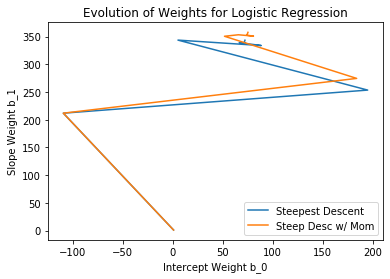

In [4]:
startW = np.ones(dim+1).reshape(-1,1)
w = [startW]
q = [startW,startW]
r = [startW]
stepsize = 1
importance = .1

# Run the chosen algorithm a certain number of times.
for i in range(1000):
    w.append(steepDesc(XTrue,w[-1],Y,stepsize))
    q.append(steepDescMom(XTrue,q[-1],q[-2],Y,stepsize,importance))
        
# Use the last weights found to predict labels.
yPred1 = predict(XTrue,w[-1])
yPred2 = predict(XTrue,q[-1])

# Compute the accuracy of the classifier from the predictions.
accuracy1 = abs(yPred1-Y)
accuracy2 = abs(yPred2-Y)
print("Steepest Descent Classifier Accuracy: "+str((len(accuracy1)-accuracy1.sum())/len(accuracy1)))
print("Steep Desc w/ Momentum Classifier Accuracy: "+str((len(accuracy2)-accuracy2.sum())/len(accuracy2)))

#Plot the path of weights.
plt.plot(*zip(*w),label="Steepest Descent")
plt.plot(*zip(*q),label="Steep Desc w/ Mom")
plt.xlabel("Intercept Weight b_0")
plt.ylabel("Slope Weight b_1")
plt.title("Evolution of Weights for Logistic Regression")
plt.legend()
plt.show()

#### Donner Party Data Fitting
Our processes have been shown to work on synthetic data, but how will they work with real data?  Let's check it with data taken from a text book of mine on the Donner party.  

In [5]:
donnerX = np.array([np.array([0,0,0,23]),np.array([1,1,1,40]),np.array([1,0,0,40]),np.array([0,0,0,30]),np.array([0,0,0,28]),
                    np.array([0,0,0,40]),np.array([1,1,1,45]),np.array([1,0,0,62]), np.array([1,0,0,65]),np.array([1,1,1,45]),
                    np.array([1,1,1,25]),np.array([1,0,0,28]),np.array([0,0,0,28]),np.array([1,0,0,23]),np.array([1,1,1,22]),
                    np.array([1,1,1,23]),np.array([1,0,0,28]),np.array([1,1,1,15]),np.array([1,1,1,47]),np.array([1,0,0,57]),
                    np.array([1,1,1,20]),np.array([1,0,0,18]),np.array([0,0,0,25]),np.array([0,0,0,60]),np.array([0,0,0,25]),
                    np.array([0,0,0,20]),np.array([1,0,0,32]),np.array([1,1,1,32]),np.array([1,1,1,24]),np.array([1,0,0,30]),
                    np.array([1,0,0,15]),np.array([1,1,1,50]),np.array([1,1,1,21]),np.array([1,0,0,25]),np.array([1,0,0,46]),
                    np.array([1,1,1,32]),np.array([0,0,0,30]),np.array([0,0,0,25]),np.array([0,0,0,25]),np.array([0,0,0,25]),
                    np.array([0,0,0,30]),np.array([0,0,0,35]),np.array([0,0,0,23]),np.array([1,0,0,24]),np.array([1,1,1,25])])
donnerY = np.array([0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,1]).reshape(-1,1)
donnerX = loadData(donnerX)
dim = donnerX[:,[0,2,4]].shape[1]
startW = np.zeros(dim).reshape(-1,1)
donnerW = [startW]
donnerQ = [startW,startW]
stepsize = .1
importance = .1

# Run the chosen algorithm a certain number of times.
for i in range(1000):
    donnerW.append(steepDesc(donnerX[:,[0,2,4]],donnerW[-1],donnerY,stepsize))
    donnerQ.append(steepDescMom(donnerX[:,[0,2,4]],donnerQ[-1],donnerQ[-2],donnerY,stepsize,importance))
        
# Use the last weights found to predict labels.
donnerPred1 = predict(donnerX[:,[0,2,4]],donnerW[-1])
donnerPred2 = predict(donnerX[:,[0,2,4]],donnerQ[-1])

# Compute the accuracy of the classifier from the predictions.
daccuracy1 = abs(donnerPred1-donnerY)
daccuracy2 = abs(donnerPred2-donnerY)
print("Steepest Descent Classifier Accuracy: "+str((len(daccuracy1)-daccuracy1.sum())/len(daccuracy1)))
print("Steep Desc w/ Momentum Classifier Accuracy: "+str((len(daccuracy2)-daccuracy2.sum())/len(daccuracy2)))
print("Steepest Desc Coefficients: "+str(donnerW[-1].T))
print("Steep Desc Mom Coefficients: "+str(donnerQ[-1].T))

Steepest Descent Classifier Accuracy: 0.7111111111111111
Steep Desc w/ Momentum Classifier Accuracy: 0.6888888888888889
Steepest Desc Coefficients: [[235.15018614 299.45259928 -14.26617122]]
Steep Desc Mom Coefficients: [[262.12693985 336.75269535 -21.83166139]]


Not fantastic.  Looks like it performs as well as the Donner party did. However, let's check to see how a prebuilt logistic regressor suite handles the data as well.  Below you'll find the SK-Learn implementation and results.  

In [6]:
clf = LogisticRegression(solver='newton-cg',penalty='none').fit(donnerX[:,[0,2,4]], donnerY.ravel())
predSK = clf.predict(donnerX[:,[0,2,4]]).reshape(-1,1)
accuracySK = (len(predSK)-abs(predSK-donnerY).sum())/len(predSK)
print("Accuracy " + str(accuracySK))
print("Coefficients " + str(clf.coef_))

Accuracy 0.7777777777777778
Coefficients [[ 0.81655514  1.59729146 -0.07820374]]


#### More Real Data: Albany (Socioeconomic Data)
Recently did a project on socioeconomic data analysis for Albany trying to determine which features of census data best predict the location of the free food fridges in Albany. There were mixed results using KNN and checking all combinations of features of computationally intractable.  Let's see how logistic regression handles it and which features it picks out when told to look through all the features.  Then we can see how it compares to the feature-sets which were found by KNN.

In [7]:
dataFrame = pd.read_csv("Dataset.csv")
fullfeaturelist = ['nei_final_simple','walk_score','transit_score','bike_score','population',
           'population_density','household_income','marital_status_married','marital_status_separated_divorce',
           'marital_status_widowed','marital_status_never_married','white_popl',
            'hispanic_popl','black_popl','asian_popl','mixed_popl','other_popl','food_stamps_total',
            'educational_attainment_no_hs','educational_attainment_bachelors','educational_attainment_very_advanced_degrees',
            'household_type_married_count', 'household_type_single_female_count',
            'household_type_single_male_count','household_type_one_person_count',
            'household_type_other_non_family_count','household_type_with_children','Age_0_to_17','Age_18_to_21',
            'Age_22_to_29','Age_30_to_39','Age_40_to_49','Age_50_to_59','Age_60_to_69','Age_70_to_79','Age_80_older']

featurelist = fullfeaturelist[1:]

# A new dataframe after removing job sector data since much of this is missing across many neighborhoods.
dfFull = dataFrame[fullfeaturelist]
# Taking out Pastures Neighborhood because of large lack of data.
df = pd.DataFrame(dfFull[dfFull['nei_final_simple']!= 'Pastures'],columns = fullfeaturelist)
# Taking out West End Neighborhood because of large lack of data.
df = pd.DataFrame(df[df['nei_final_simple'] != 'West End'],columns = fullfeaturelist)
df.reset_index(drop = True, inplace=True)

scaler = MaxAbsScaler()
scaler.fit(df[featurelist])
scaledData = scaler.transform(df[featurelist])
dfScaled = pd.DataFrame(scaledData,columns=featurelist)
dfScaled['nei_final_simple']=df['nei_final_simple']
dfScaled.insert(0,'Ones',1)

# Labels WITHOUT Eagle Hill and Pastures included.
dfScaled.loc[:,'fridge_count'] = pd.Series(np.array([1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0]),index=dfScaled.index)

In [8]:
fridgeX = np.array(dfScaled[['Ones',*featurelist]])
fridgeY = np.array(dfScaled['fridge_count']).reshape(-1,1)
dim = fridgeX.shape[1]
startW = np.zeros(dim).reshape(-1,1)
stepsize = .1
importance = .1

testcount = 3
accList = []
for k in range(500):
    fridgeW = [startW]
        
    trainIndices = random.sample(list(np.arange(fridgeX.shape[0])),len(fridgeY)-testcount)
    trainIndices = [*trainIndices,0,1] #Need to include at least one class 1 and 0 in training.
    testIndices = [i for i in range(fridgeX.shape[0]) if i not in trainIndices]
    fridgeXTrain = fridgeX[trainIndices]
    fridgeXTest = fridgeX[testIndices]
    fridgeYTrain = fridgeY[trainIndices]
    fridgeYTest = fridgeY[testIndices]

# Run the chosen algorithm a certain number of times.
# We will leave out the last five neighborhoods for testing.
    for i in range(200):
        fridgeW.append(steepDesc(fridgeXTrain,fridgeW[-1],fridgeYTrain,stepsize))
        
# Use the last weights found to predict labels.
    fridgePred1 = predict(fridgeXTest,fridgeW[-1])

# Compute the accuracy of the classifier from the predictions.
    fridgeaccuracy1 = abs(fridgePred1-fridgeYTest)
    
    accList.append((len(fridgeaccuracy1)-fridgeaccuracy1.sum())/len(fridgeaccuracy1))
print("Average Accuracy: "+str(sum(accList)/len(accList)))

Average Accuracy: 0.7003333333333339


First, I'd like to say just how good this is at first blush.  KNN struggled to get accuracies close to 0.80 with a lot of tweaking and selecting precise features.  This method obtains descent results when using all features out of the gate.

In [9]:
accList = []
testcount=3
for k in range(500):
    trainIndices = random.sample(list(np.arange(fridgeX.shape[0])),testcount)
    trainIndices = [*trainIndices,0,1] #Need to include at least one class 1 and 0 in training.
    testIndices = [i for i in range(fridgeX.shape[0]) if i not in trainIndices]
    fridgeXTrain = fridgeX[trainIndices]
    fridgeXTest = fridgeX[testIndices]
    fridgeYTrain = fridgeY[trainIndices]
    fridgeYTest = fridgeY[testIndices]

    clf = LogisticRegression(solver='newton-cg',penalty='none').fit(fridgeXTrain, fridgeYTrain.ravel())
    predSK = clf.predict(fridgeXTest)
    accList.append((len(predSK)-abs(predSK.reshape(-1,1)-fridgeYTest).sum())/len(predSK))
    
print("Average Accuracy: "+str(sum(accList)/len(accList)))

Average Accuracy: 0.6786405044231133


And the prebuilt stuff for logistic regression is noticeably faster than that for KNN.  Would have had better results sooner.  Now, let's check some known sets of features which provide very good KNN classifiers ($acc > 0.90$).

Here are just some of the five feature sets with over 0.90 accuracy
* 'bike_score', 'population_density', 'other_popl', 'household_type_married_count', 'household_type_one_person_count'
* 'population_density', 'other_popl', 'educational_attainment_very_advanced_degrees', 'household_type_married_count', 'household_type_single_male_count'
* 'population_density', 'marital_status_married', 'black_popl', 'other_popl', 'educational_attainment_very_advanced_degrees'
* 'population_density', 'marital_status_married', 'black_popl', 'other_popl', 'Age_80_older'

In [10]:
featurelist1 = ['bike_score', 'population_density', 'other_popl', 'household_type_married_count', 'household_type_one_person_count']
featurelist2 = ['population_density', 'other_popl', 'educational_attainment_very_advanced_degrees', 'household_type_married_count', 'household_type_single_male_count']
featurelist3 = ['population_density', 'marital_status_married', 'black_popl', 'other_popl', 'educational_attainment_very_advanced_degrees']
featurelist4 = ['population_density', 'marital_status_married', 'black_popl', 'other_popl', 'Age_80_older']
featurelists = [featurelist1, featurelist2, featurelist3, featurelist4]
    
selectFridgeXs = [np.array(dfScaled[['Ones',*lists]]) for lists in featurelists]
selectFridgeYs = np.array(dfScaled['fridge_count']).reshape(-1,1)
dim = selectFridgeXs[0].shape[1]

accList = []
testcount=3
count = 1
for Xs in selectFridgeXs:
    for k in range(500):
        trainIndices = random.sample(list(np.arange(Xs.shape[0])),testcount)
        trainIndices = [*trainIndices,0,1] #Need to include at least one class 1 and 0 in training.
        testIndices = [i for i in range(Xs.shape[0]) if i not in trainIndices]
        fridgeXTrain = Xs[trainIndices]
        fridgeXTest = Xs[testIndices]
        fridgeYTrain = selectFridgeYs[trainIndices]
        fridgeYTest = selectFridgeYs[testIndices]

        clf = LogisticRegression(solver='newton-cg',penalty='none').fit(fridgeXTrain, fridgeYTrain.ravel())
        predSK = clf.predict(fridgeXTest)
        accList.append((len(predSK)-abs(predSK.reshape(-1,1)-fridgeYTest).sum())/len(predSK))
    print("Feature list: "+str(count))
    print("Average Accuracy: "+str(sum(accList)/len(accList)))
    count = count +1

Feature list: 1
Average Accuracy: 0.5881765480895917
Feature list: 2
Average Accuracy: 0.6373860342556003
Feature list: 3
Average Accuracy: 0.658728966685493
Feature list: 4
Average Accuracy: 0.6713307923960222


Fascinating, that selecting features for KNN to provide high accuracies does not imply that the same feature set will perform well with logistic regression.  In fact, these featuresets perform terribly by comparison.  Fascinating, and cautionary.  I'm not sure why I assumed this, but I'm glad to be put in my place.  Learning is not that straightforward.

#### Conclusion
In regards to my implementations, slower.  But, it looks like my methods work and are comparable in accuracy to the prebuilt ones.  That's encouraging.  I am very thankful for the ladies and gentlemen that have built all of what I did (and more and in more efficient ways) so that I can write three lines of code instead of spending multiple days hashing this out.  

In regards to my project with KNN on socioeconomic data, while I would have learned a lot about logistic regression in and had great results out of the gate I am glad to have compared the two after the fact.  There are very good points to draw from this brief venture.

Overall, this was a good experience for the learning that took place.